# WPA results

In [1]:
import pandas as pd
import numpy as np
import re
import glob
import random
from random import sample
import json
import jsonlines
import pysbd
seg = pysbd.Segmenter(language="en", clean=False) # sentence segmenter
import spacy
from spacy import displacy

In [2]:
custom_ner_model = spacy.load("../../specimen-ner/output/model-best/")

In [3]:
def json2txt_df(json_file_path):
    """
    Extract body text of json file
    """
    with open(json_file_path, 'r') as f:
        data = json.loads(f.read())
        body_text_df = pd.json_normalize(data["pdf_parse"]["body_text"])
    
    return body_text_df

def df2sentences(df):
    """
    Tokenize and clean sentences
    """
    sentences_text = " ".join(list(df.text)) 
    pattern_brackets = re.compile(r'\(.*?\)')
    sentences_text = re.sub(pattern_brackets, "", sentences_text) 
    sentences = seg.segment(sentences_text) 
    sentences = [re.sub(r"^\W+", "", sentence) for sentence in sentences] 
    sentences = [re.sub(r"\s+", " ", sentence) for sentence in sentences]
    return sentences

def prep_data(json_file_path, ref_id):
    """
    Return sentence lists for matches
    """
    body_text_df = json2txt_df(json_file_path)
    sentences = df2sentences(body_text_df)
    candidates = []
    for sentence in sentences:
        doc = nlp(sentence)
        matches = matcher(doc)
        if len(matches) > 0:
            sentence_dict = {"text":sentence,
                             "meta":{"ref_id":str(ref_id)}}
            candidates.append(sentence_dict)    
    return candidates

def clean_text(txt):
    """
    Removes special characters, punctuation, and returns lowercase
    """
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower())

def clean_text2(txt):
    """
    Removes special characters and punctuation
    """
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt))

def alphanum(txt):
    """
    Extracts alphanumeric characters without spaces
    """
    return "".join(x.lower() for x in txt if x.isalnum())

def extract_pat(search_str:str, search_list:str):
    """
    Defines pattern to search for
    """
    search_obj = re.search(search_list, search_str)
    if search_obj:
        return_str = search_str[search_obj.start(): search_obj.end()]
    else:
        return_str = "None"
    return return_str

def extract_ents(text):
    """
    Extract named entities, and beginning, middle and end idx     
    """
    doc = custom_ner_model(text)
    if len(doc.ents) > 0:
        return clean_text2(doc.ents)
    else:
        return None

def predict_ents(df):
    """
    Create new column in data frame with named entity tuple extracted
    """
    df_sent['specimen_prediction'] = df_sent['sent'].apply(extract_ents)

In [4]:
wpa_papers = glob.glob('/nfs/turbo/isr-slafia/specimen/bibliography_wpa_json/*.json')
print(f"Looking for SPECIMEN entities in {len(wpa_papers)} WPA papers")

Looking for SPECIMEN entities in 46 WPA papers


Example of predictions for one paper

In [5]:
%%time

papers_sample = random.sample(wpa_papers, 1)

for file in papers_sample:
    ref_id = file.split("/")[-1].split("-")[0]
    print(f"Searching for SPECIMEN entities in paper: {ref_id}")
    body_text_df = json2txt_df(file)
    sentence_list = df2sentences(body_text_df)
    for sentence in sentence_list:
        clean_sent = clean_text2(sentence)
        doc = custom_ner_model(clean_sent)
        if len(doc.ents) > 0:
            displacy.render(doc, style="ent", jupyter=True)

Searching for SPECIMEN entities in paper: Gibson2018


CPU times: user 48.6 s, sys: 261 ms, total: 48.9 s
Wall time: 1min 19s


Find all predictions for all papers

In [6]:
%%time

df_test_pubs = pd.DataFrame()
for test_file in wpa_papers:
    with open(test_file, 'r') as f:
        data = json.loads(f.read())
        file_data = pd.json_normalize(data["pdf_parse"]["body_text"])
        file_data["paper_id"] = data["title"]
    df_test_pubs = pd.concat([df_test_pubs, file_data])

wpa_sentences = []

for row in df_test_pubs.itertuples():
    for sent in seg.segment(row[1]):
        wpa_sentences.append((row[7], row[5], row[7], sent))
        
df_sent = pd.DataFrame(wpa_sentences, columns=['Id', 'section_title', 'paper_title', 'sent'])
df_sent['sent'] = df_sent['sent'].astype(str)
df_sent
    
predict_ents(df_sent)

df_sent['specimen_prediction'].value_counts().sort_values(ascending=False)

CPU times: user 44min 35s, sys: 5.43 s, total: 44min 41s
Wall time: 1h 26min 19s


 TMM 42452 1                                     38
 TMM 46052 1                                     17
 WPA                                             16
 TMM 45947 524                                   16
 WPA 3                                           13
                                                 ..
 NMMNH P 41400 preserves                          1
 NMMNH P 29959 than TMM specimens                 1
 NMMNH P 29959 are                                1
 NMMNH P 41400 NMMNH locality 3775                1
 NMC 8817 NMC 192 NMC 38079 UALVP 2 ZPAL MgD      1
Name: specimen_prediction, Length: 814, dtype: int64

Total times mentioned across corpus

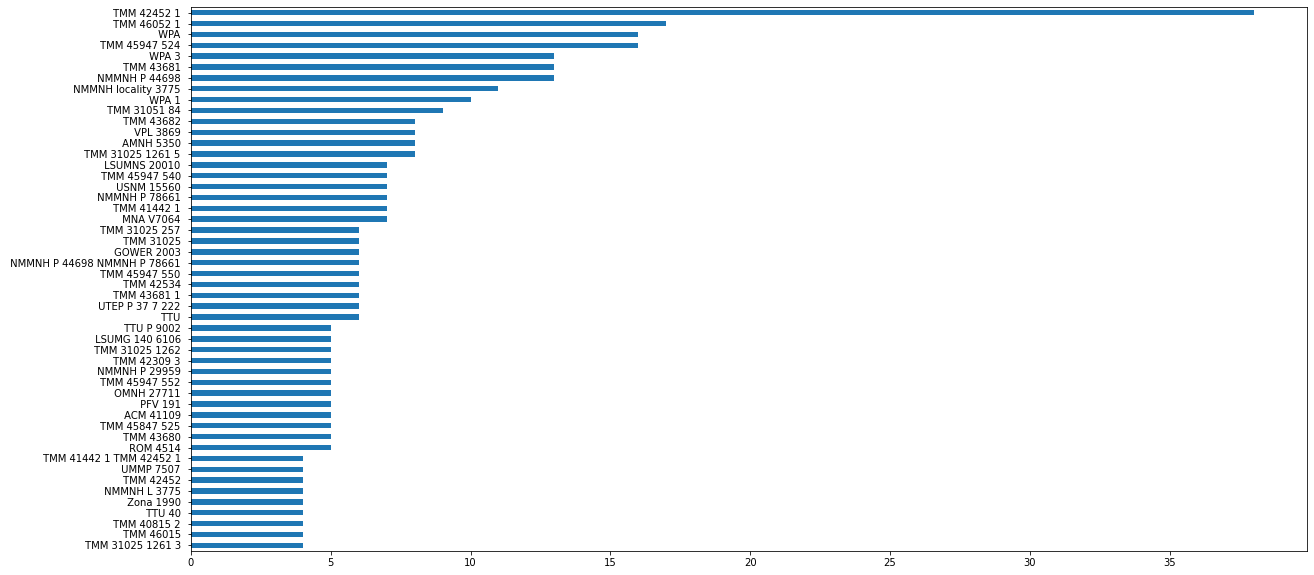

In [11]:
import matplotlib.pyplot as plt

fig = df_sent['specimen_prediction'].value_counts().nlargest(50).sort_values().plot(kind='barh',figsize=(20,10))
plt.savefig('../../specimen-ner/results/wpa_specimen_count.png', dpi=300)

In [8]:
wpa_unique_codes = set(df_sent['specimen_prediction'].unique())
len(wpa_unique_codes)

815

Unique specimens per paper

<AxesSubplot:ylabel='paper'>

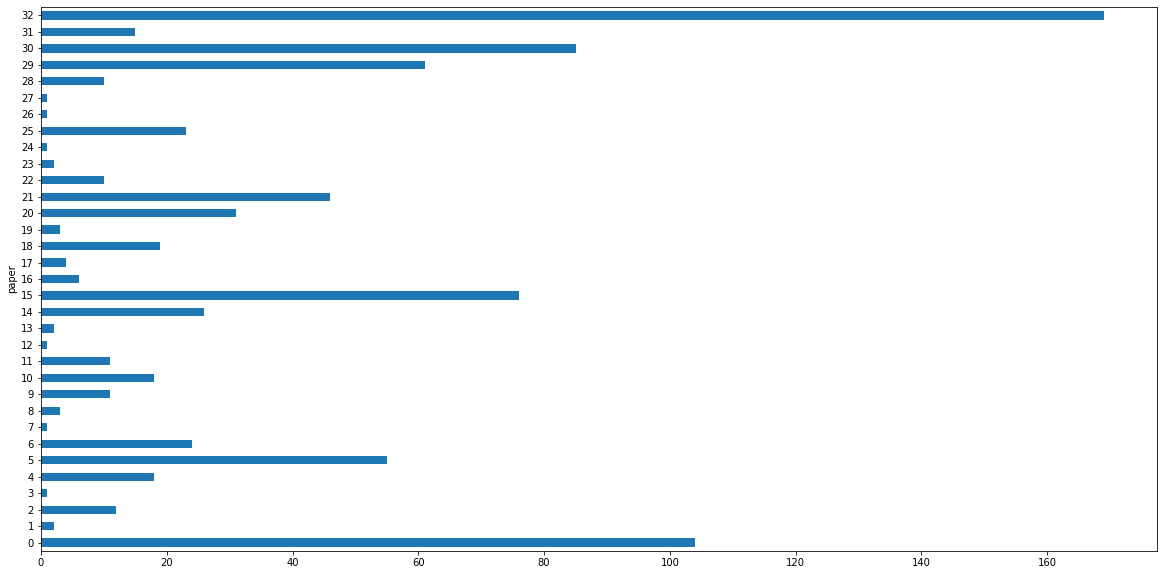

In [33]:
predictions_wpa = df_sent[df_sent.specimen_prediction.notna()]
predictions_wpa = predictions_wpa[predictions_wpa.Id.notna()]
predictions_wpa['paper'] = predictions_wpa['Id'].astype("category").cat.codes

predictions_wpa['Id'] = predictions_wpa[['Id','paper','specimen_prediction']].groupby(['specimen_prediction','paper'])['Id'].transform(lambda x: ','.join(x))
predictions_wpa.to_csv('../../specimen-ner/results/predictions_wpa.csv',index=False)

predictions_wpa_dedup = predictions_wpa[['specimen_prediction','Id','paper']].drop_duplicates()
predictions_wpa_dedup.to_csv('../../specimen-ner/results/specimens_per_paper_wpa.csv')
predictions_wpa_dedup.groupby("paper")["specimen_prediction"].count().plot(kind='barh',figsize=(20,10))

In [9]:
cross_df = pd.crosstab(predictions_wpa_dedup.specimen_prediction, predictions_wpa_dedup.paper, margins=True, dropna=False)
cross_df.to_csv('../../specimen-ner/results/frequency_wpa.csv')
cross_df

paper,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,All
specimen_prediction,,,,,,,,,,,,,,,,,,,,,
A 1468,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
ACM 41109,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
ACM 578 AMNH 5350 MNHM v345 NMC 2278 ROM 4514 YPM PU 16970,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
AMH 5350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
AMNH 30,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YPM PU 16970,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
YPM PU 16970 is,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
Zona 1990,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
